<a href="https://colab.research.google.com/github/Ahmedxr9/disorder_silent/blob/main/Disorder_ahmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import seaborn as sns

import os
import pandas as pd
from IPython.display import Audio
import tensorflow as tf

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
pathDisorfer = "/content/drive/My Drive/silent_spp/Disorder Voices/Disorder Voices/" ## put the right directory
pathNormal = "/content/drive/My Drive/silent_spp/Normal Voices/Normal Voices/" ## put the right directory

In [25]:
voicePathDirs = os.listdir(pathDisorfer)
voiceNormDirs = os.listdir(pathNormal)

file_voices = []
file_path = []

for file in voicePathDirs:
    # storing file paths
    file_path.append(pathDisorfer + file)
    file_voices.append('pathology')

for file in voiceNormDirs:
    file_path.append(pathNormal + file)
    file_voices.append('normal')
# dataframe for pathology classification of files
voices_df = pd.DataFrame(file_voices, columns=['Voices'])

# dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
voiceData_df = pd.concat([voices_df, path_df], axis=1)
voiceData_df.to_csv("voiceData_df.csv",index=False)
voiceData_df.head()

,Voices,Path
0,pathology,/content/drive/My Drive/silent_spp/Disorder Vo...
1,pathology,/content/drive/My Drive/silent_spp/Disorder Vo...
2,pathology,/content/drive/My Drive/silent_spp/Disorder Vo...
3,pathology,/content/drive/My Drive/silent_spp/Disorder Vo...
4,pathology,/content/drive/My Drive/silent_spp/Disorder Vo...


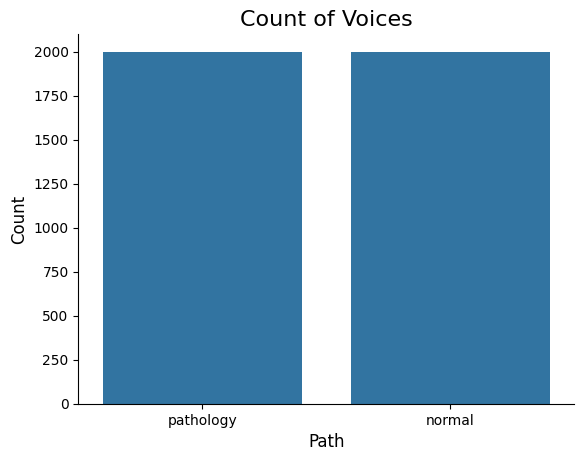

In [26]:
# plot of the number of voice types in the dataset
plt.title('Count of Voices', size=16)
sns.countplot(data=voiceData_df, x="Voices")
plt.ylabel('Count', size=12)
plt.xlabel('Path', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [27]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio {} voice'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio {} voice'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

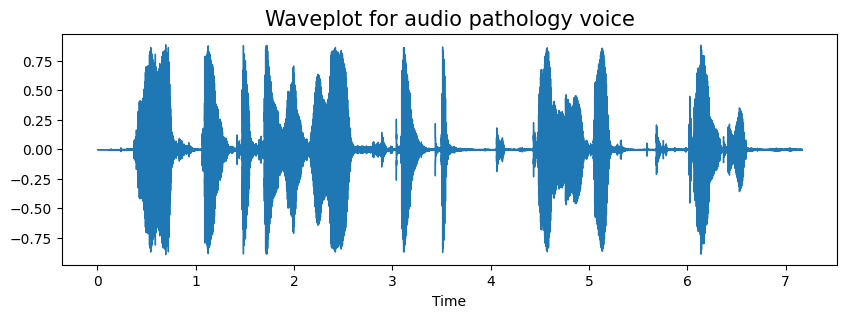

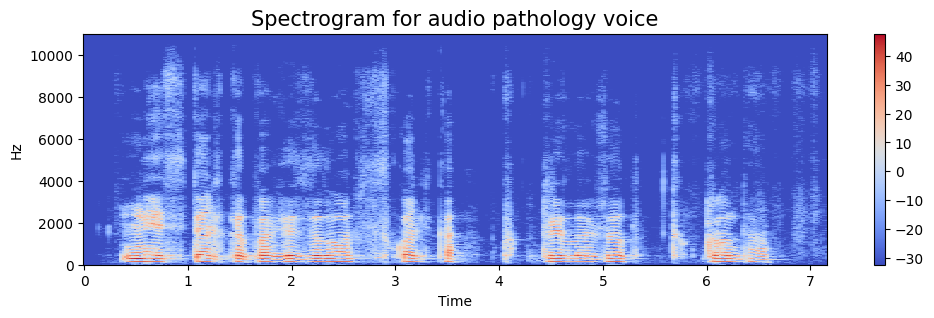

In [28]:
typeVoice='pathology'
path = np.array(voiceData_df.Path[voiceData_df.Voices==typeVoice])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, typeVoice)
create_spectrogram(data, sampling_rate, typeVoice)
Audio(path)

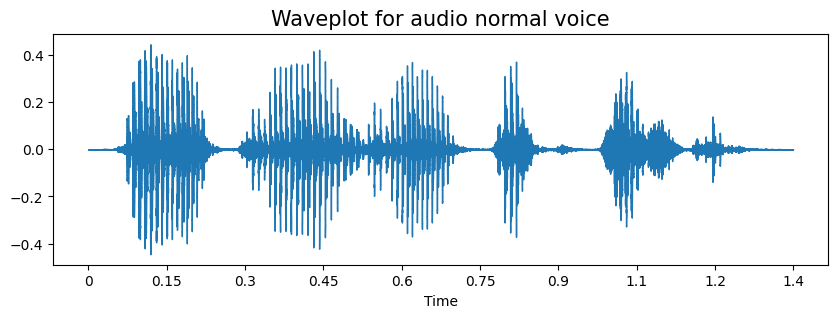

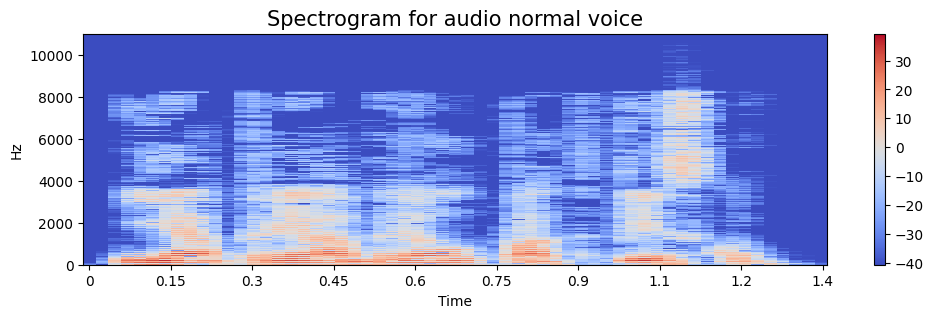

In [29]:
typeVoice='normal'
path = np.array(voiceData_df.Path[voiceData_df.Voices==typeVoice])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, typeVoice)
create_spectrogram(data, sampling_rate, typeVoice)
Audio(path)

In [30]:
!pip install noisereduce
!pip install vad
!pip install pydub

In [32]:
from pydub import AudioSegment
import noisereduce as nr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from vad import EnergyVAD
from pydub.silence import split_on_silence

In [33]:
def extract_features(data, sample_rate):
    result = np.array([])

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    return result

def reduce_noise(path):
    audio_data, sample_rate = librosa.load(path)
    audio = AudioSegment(audio_data.tobytes(), frame_rate=16000, sample_width=2, channels=1)
    silence_thresh = -10
    chunks = split_on_silence(audio, min_silence_len=500, silence_thresh=silence_thresh)

    reduced_audio = chunks[0]
    for chunk in chunks[1:]:
        reduced_audio += chunk

    return reduced_audio, sample_rate

def get_features(path):
    reduced_audio, sample_rate = reduce_noise(path)
    audio_data = np.array(reduced_audio.get_array_of_samples(), dtype=np.float32) / np.iinfo(np.int16).max
#     audio_data = np.array(reduced_audio.get_array_of_samples())

    max_amplitude = np.max(np.abs(audio_data))  # Calculate the maximum amplitude

    result = extract_features(audio_data, sample_rate)

    return result


In [34]:
X, Y = [], []
for path, voice in zip(voiceData_df.Path, voiceData_df.Voices):
    if (librosa.get_duration(path=path)!= 0):
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            Y.append(voice)
    else:
        print('audiofile {0} is empty'.format(path))

audiofile /content/drive/My Drive/silent_spp/Normal Voices/Normal Voices/382.wav is empty
audiofile /content/drive/My Drive/silent_spp/Normal Voices/Normal Voices/388.wav is empty
audiofile /content/drive/My Drive/silent_spp/Normal Voices/Normal Voices/398.wav is empty


In [35]:
len(X), len(Y), voiceData_df.Path.shape

(3997, 3997, (4000,))

In [36]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,labels
0,0.540080,pathology
1,0.540571,pathology
2,0.540193,pathology
3,0.540069,pathology
4,0.540768,pathology


In [37]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [38]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2997, 1), (2997, 2), (1000, 1), (1000, 2))

In [40]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2997, 1), (2997, 2), (1000, 1), (1000, 2))

In [41]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((2997, 1, 1), (2997, 2), (1000, 1, 1), (1000, 2))

In [42]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 256)              │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 256)              │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1, 128)              │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1, 64)               │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 637,474 (2.43 MB)

 Trainable params: 637,474 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.6582 - loss: 0.6319 - val_accuracy: 0.8280 - val_loss: 0.3868 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8547 - loss: 0.3743 - val_accuracy: 0.8390 - val_loss: 0.3813 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8441 - loss: 0.3781 - val_accuracy: 0.8360 - val_loss: 0.3718 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8383 - loss: 0.3811 - val_accuracy: 0.8370 - val_loss: 0.3845 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.8511 - loss: 0.3630 - val_accuracy: 0.8400 - val_loss: 0.3680 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8372 - loss: 0.3759 - val_accuracy: 0.8390 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8417 - loss: 0.3667 - val_a

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8417 - loss: 0.3456
Accuracy of our model on test data :  83.09999704360962 %


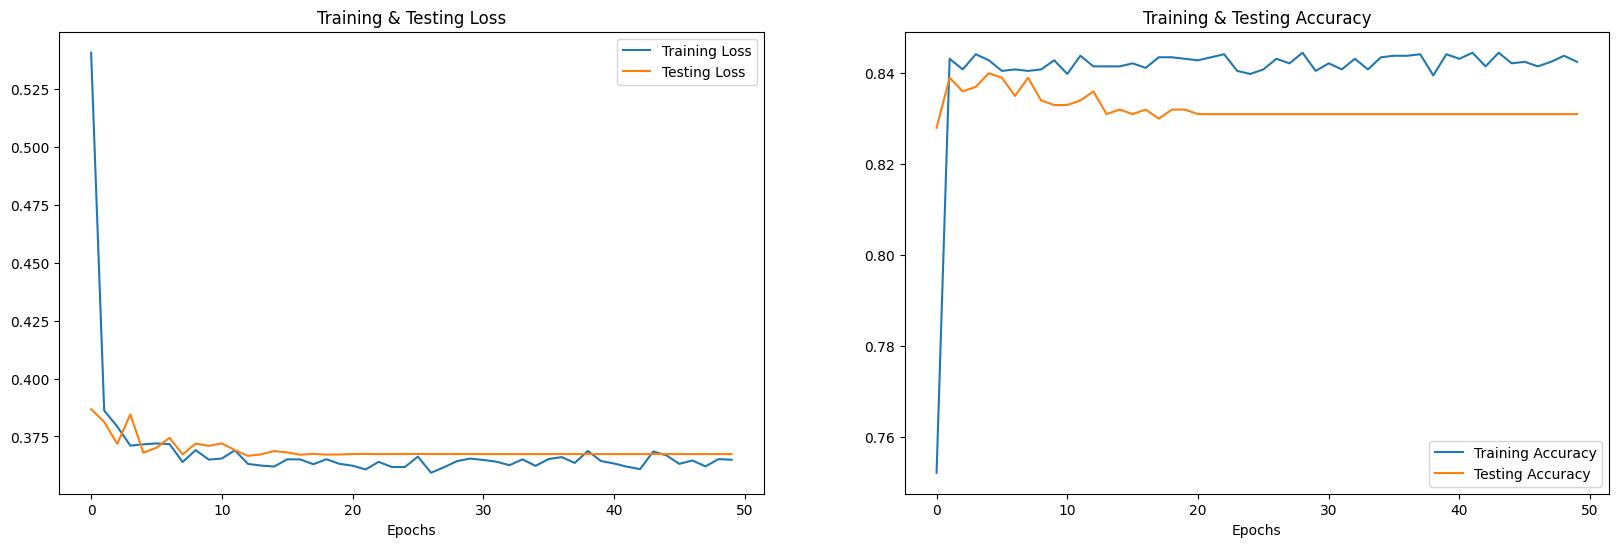

In [44]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [45]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [46]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,pathology,pathology
1,pathology,normal
2,pathology,pathology
3,pathology,pathology
4,normal,pathology
5,normal,normal
6,normal,pathology
7,pathology,pathology
8,normal,normal
9,pathology,normal


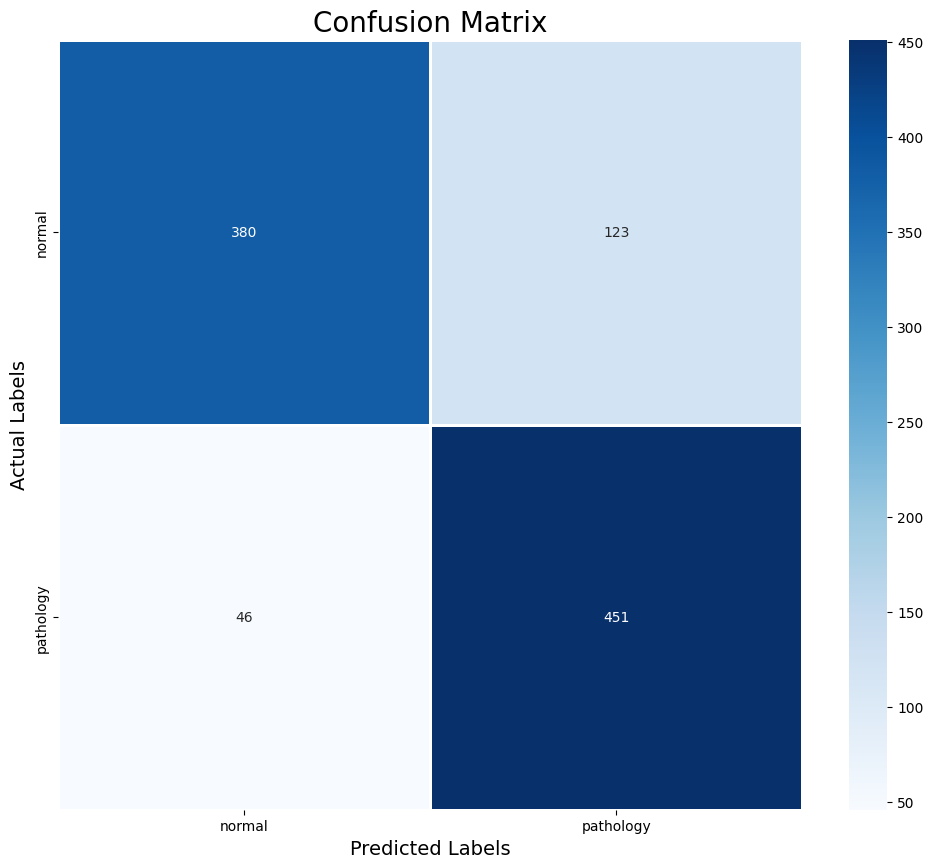

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      normal       0.89      0.76      0.82       503
   pathology       0.79      0.91      0.84       497

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.83      0.83      1000



In [50]:
model.save("Voice-Classification-Model.keras")